### 필요한 라이브러리를 설치 및 임포트합니다.


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! unzip /content/drive/MyDrive/공군_미니해커톤/copy_dataset/dataset/train.zip -d /content/drive/MyDrive/공군_미니해커톤/copy_dataset/dataset/

In [3]:
# ! unzip /content/drive/MyDrive/공군_미니해커톤/copy_dataset/dataset/test.zip -d /content/drive/MyDrive/공군_미니해커톤/copy_dataset/dataset/

In [1]:
# 라이브러리를 임포트합니다.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from glob import glob
import directory_tree
import PIL.Image as Image
import imgviz
import seaborn as sns
import cv2
import plotly.io as pio # Plotly input output
import plotly.express as px # 빠르게 그리는 방법
import plotly.graph_objects as go # 디테일한 설정
from tqdm import tqdm 

pio.templates.default = 'plotly_white' # 템플릿을 지정합니다.

warnings.filterwarnings(action='ignore')

### 데이터의 저장 구조를 확인합니다.

In [5]:
data_directory = '/scratch/network/mk8574/crack_detection_challenge/data' # 데이터 디렉토리 경로를 지정합니다.
directory_tree.display_tree(data_directory, header=True, max_depth=2)


$ Operating System : Linux
$ Path : /scratch/network/mk8574/crack_detection_challenge/data
    
*************** Directory Tree ***************

data/
├── test/
│   ├── images/
│   └── sample_submission.zip
└── train/
    ├── images/
    └── masks/


### 실제 이미지를 확인해봅니다.

In [6]:
# 이미지가 어떻게 생겼는지 확인해봅니다.
## 학습용 데이터 디렉토리
train_image_directory = os.path.join(data_directory, 'train', 'images')
train_mask_directory = os.path.join(data_directory, 'train', 'masks')

# 평가용 데이터 디렉토리
test_image_directory = os.path.join(data_directory, 'test', 'images')

# 데이터 파일 경로를 리스트로 저장합니다.
train_image_paths = sorted(glob(os.path.join(train_image_directory, '*.jpg')))
train_mask_paths = sorted(glob(os.path.join(train_mask_directory, '*.png')))
test_image_paths = sorted(glob(os.path.join(test_image_directory, '*.jpg')))

# 각 데이터의 수량을 확인합니다.
print(f'학습용 이미지 : {len(train_image_paths)}개, 학습용 마스크 : {len(train_mask_paths)}개, 평가용 이미지 : {len(test_image_paths)}개')

학습용 이미지 : 5986개, 학습용 마스크 : 5986개, 평가용 이미지 : 3992개


In [7]:
def image_grid_show(image_list):
    # 이미지를 그리드 형태로 보여주는 함수입니다.
    fig = plt.figure(figsize=(20, 20))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(image_list[i]))
        plt.title(image_list[i].split('/')[-1])
        plt.axis('off')

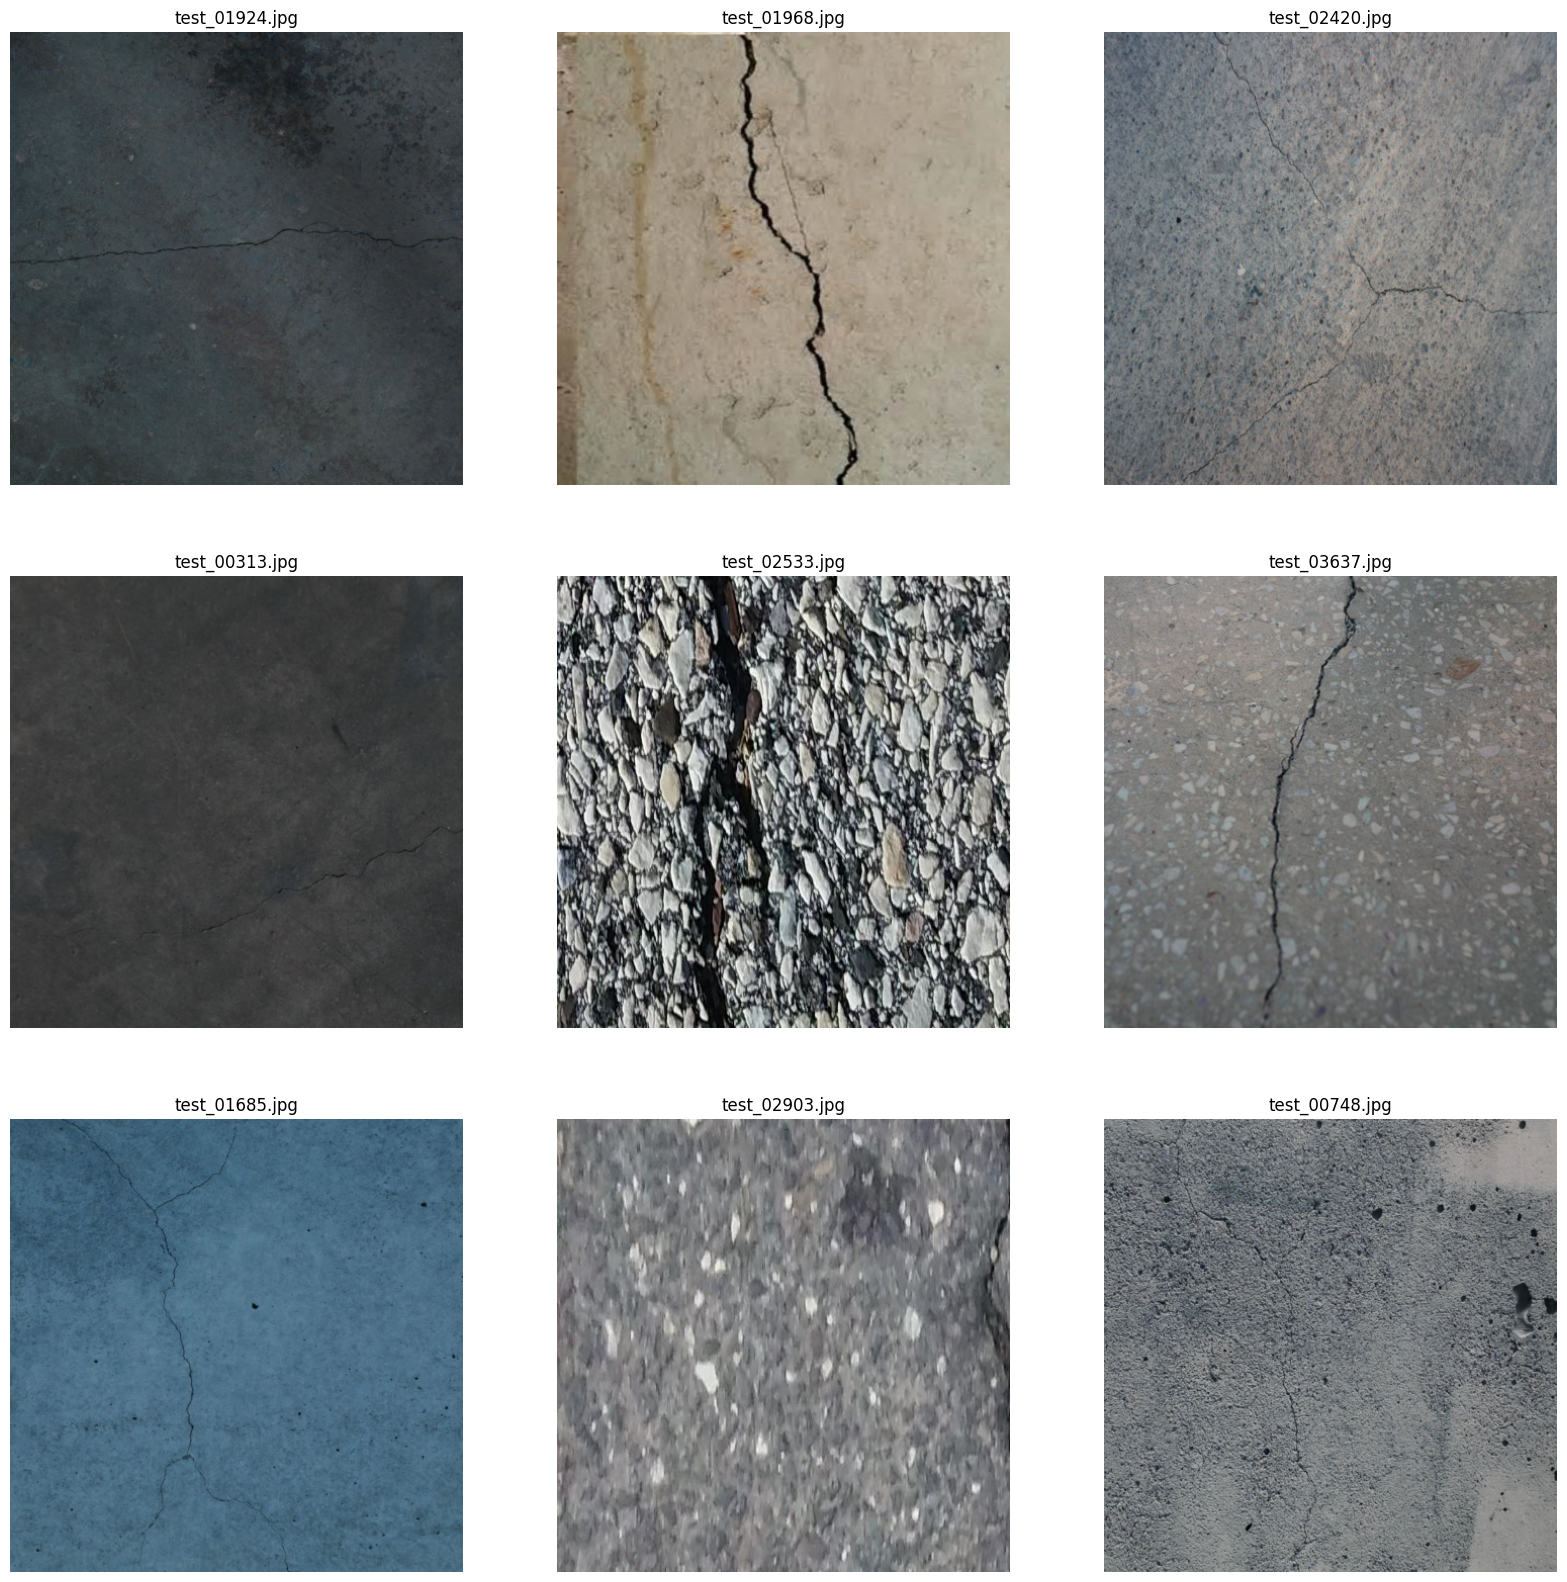

In [8]:
# 이미지를 9개씩 뽑아서 랜덤하게 보여줍니다.
image_grid_show(np.random.choice(test_image_paths, 9))

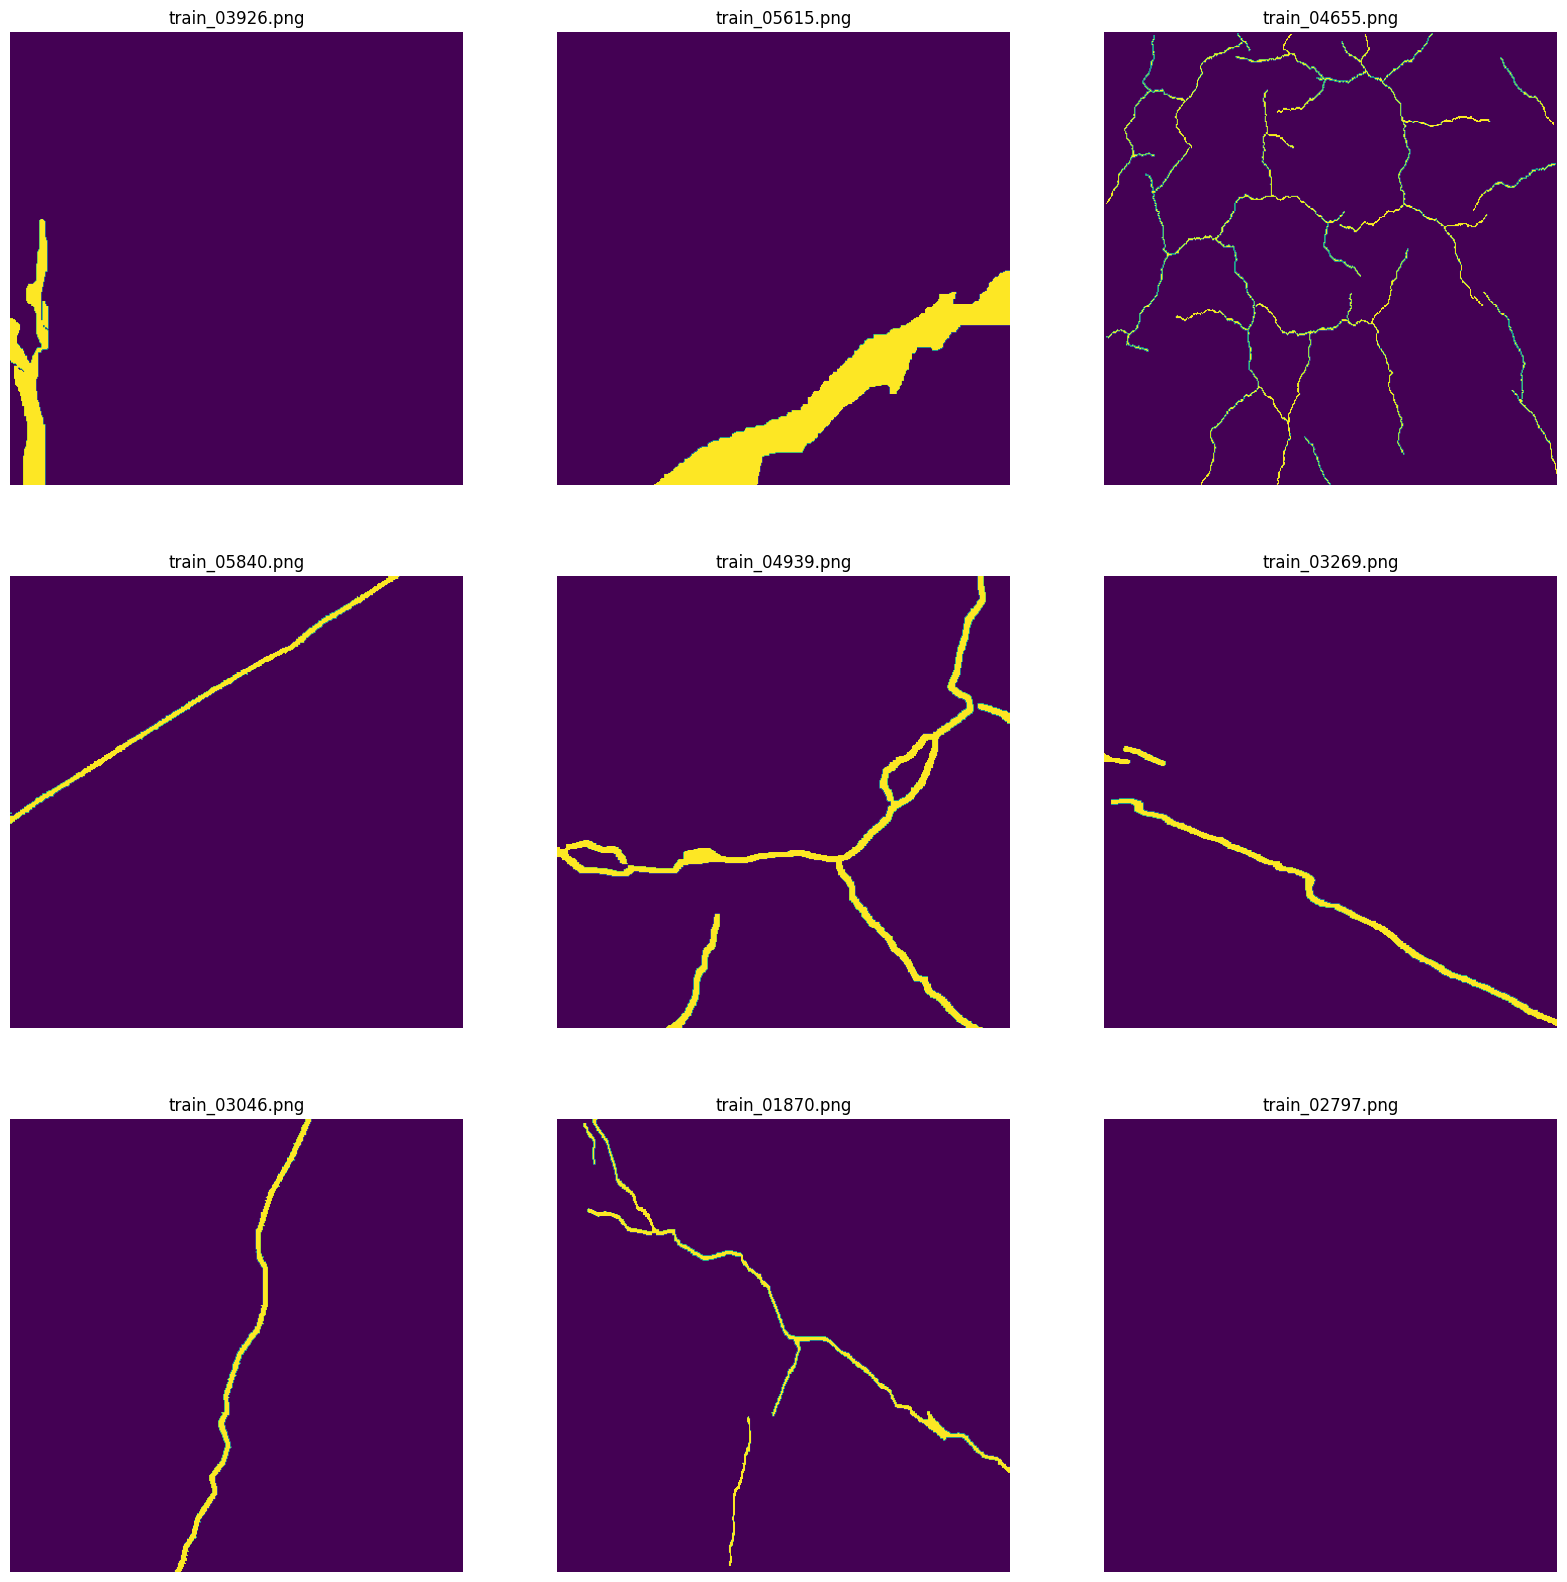

In [9]:
# 마스크 이미지를 9개씩 뽑아서 랜덤하게 보여줍니다.
image_grid_show(np.random.choice(train_mask_paths, 9))

In [10]:
def image_mask_overlap_grid(image_list, mask_list):
    # 이미지를 그리드 형태로 보여주는 함수입니다.
    class_names = ['normal', 'crack']
    fig = plt.figure(figsize=(20, 20))
    for i in range(9):
        img = np.array(Image.open(image_list[i]).convert('L'))
        mask = np.array(Image.open(mask_list[i]).convert('L'))
        overlapped_image = imgviz.label2rgb(mask, image=img, label_names=class_names, font_size=25)
        plt.subplot(3, 3, i+1)
        plt.imshow(overlapped_image)
        plt.title(image_list[i].split('/')[-1])
        plt.axis('off')

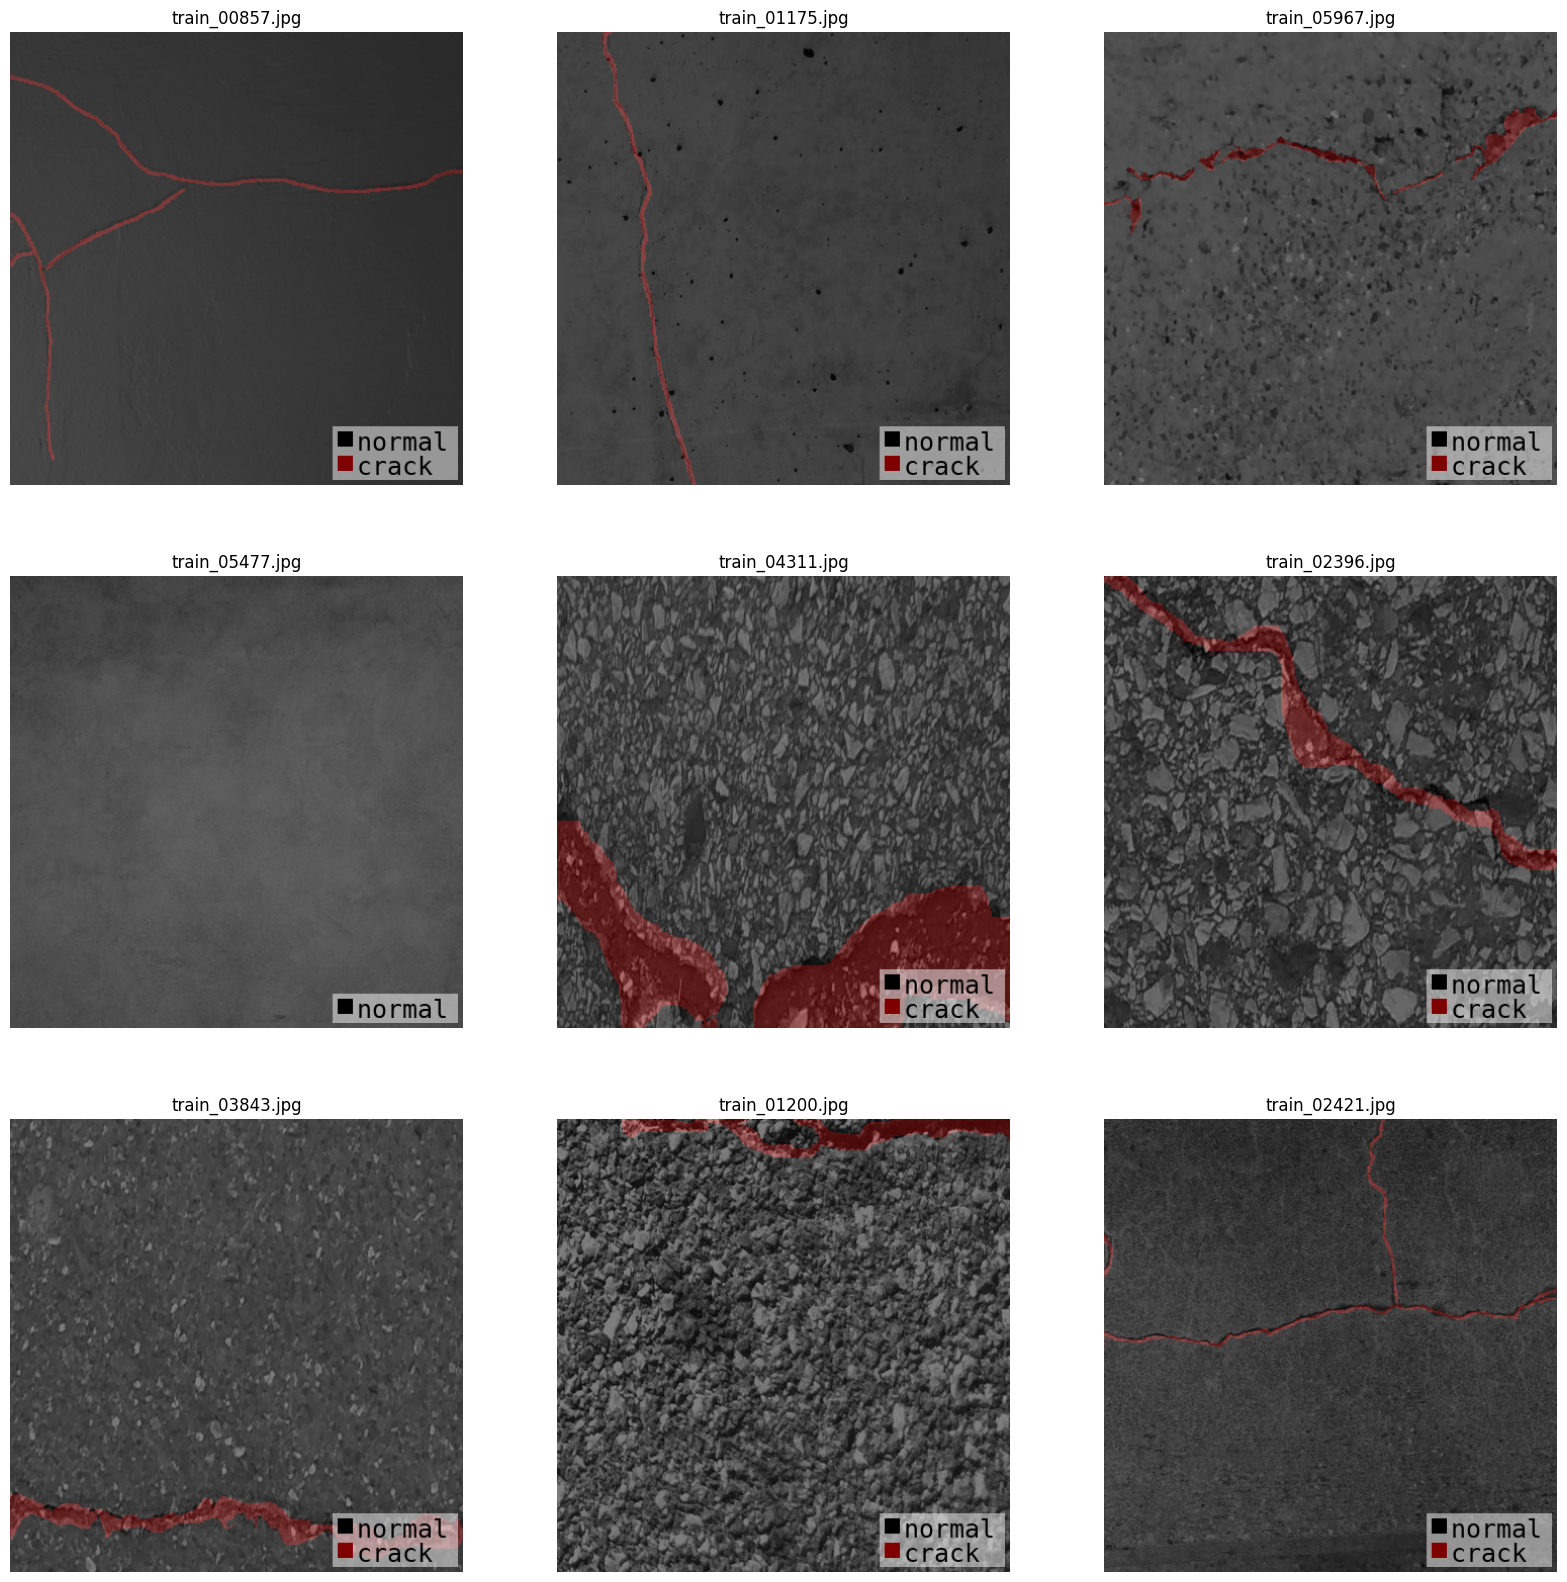

In [11]:
selected_image = np.random.choice(train_image_paths, 9)
selected_mask = [i.replace('images', 'masks').replace('jpg', 'png') for i in selected_image]
image_mask_overlap_grid(selected_image, selected_mask)

### 분포 확인

In [12]:
# image 사이즈 분포를 확인해봅니다.
from collections import defaultdict

image_size_dict = defaultdict(int)

for img_path in tqdm(train_image_paths):
    img = np.array(Image.open(img_path))
    image_size_dict[img.shape] += 1

100%|██████████| 5986/5986 [00:14<00:00, 412.09it/s]


In [13]:
image_size_dict

defaultdict(int, {(448, 448, 3): 5986})

In [14]:
# image 사이즈 분포를 확인해봅니다.
image_size_dict = defaultdict(int)

for img_path in tqdm(test_image_paths):
    img = np.array(Image.open(img_path))
    image_size_dict[img.shape] += 1

100%|██████████| 3992/3992 [00:09<00:00, 415.79it/s]


In [16]:
image_size_dict

defaultdict(int, {(448, 448, 3): 3992})

In [17]:
# crack의 크기 분포를 확인해봅시다.

crack_size_list = []

for mask_path in tqdm(train_mask_paths):
    mask = np.array(Image.open(mask_path))
    if 1 in mask:
        crack_size_list.append(np.sum(mask))

# # crack의 크기 분포를 시각화합니다.
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=crack_size_list, name='crack size'))

100%|██████████| 5986/5986 [00:03<00:00, 1896.35it/s]


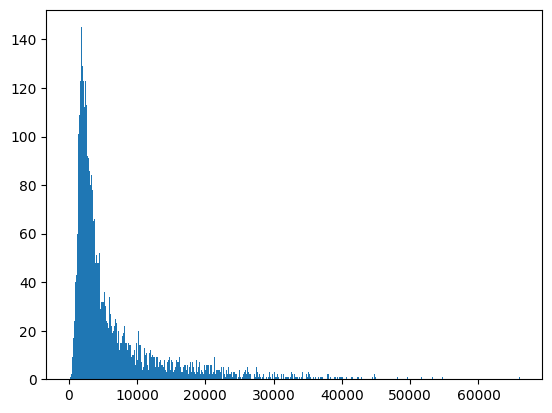

In [26]:
binwidth = 100

plt.hist(crack_size_list, bins = np.arange(min(crack_size_list), max(crack_size_list) + binwidth, binwidth))
plt.show()